In [1]:
import sys
import pennylane as qml
from pennylane import numpy as np
from math import pi
from sklearn import datasets
import scipy
import numpy as np
import time
import math

In [2]:
numQubits = 4
depth = 9
d = 40

In [3]:
dev = qml.device("default.qubit", wires=numQubits)

In [4]:
def add_layerRZ(data):
    for i in range(numQubits):
        qml.RZ(data[i], wires = i)

def make_feature_map(data):
    for i in range(numQubits):
        qml.Hadamard(wires = i)
    add_layerRZ(data)

In [5]:
def add_cnots():
    for i in range(0, numQubits-1):
        for j in range(i+1, numQubits):
            qml.CNOT(wires = [i, j])

def add_layerRY(params):
    for qubit in range(numQubits):
        qml.RY(params[qubit], wires = qubit)
        
def make_variationalCircuit(params):
    add_cnots()
    add_layerRY(params)

In [6]:
def make_final_circuit(data, params, depth):
    make_feature_map(data)
    add_layerRY(params[0:numQubits])
    for i in range(depth):
        make_variationalCircuit(params[numQubits*(i+1):numQubits*(i+2)])

In [7]:
@qml.qnode(dev)
def qnode(params):
    make_final_circuit(data, params, depth)
    return qml.expval(qml.PauliX(1))

In [8]:
@qml.qnode(dev)
def fubini_qnode(data, params,depth):
    make_final_circuit(data, params,depth)
    return qml.state()

In [9]:
def fubini_calculate(data, params,depth):
    fubini = np.zeros([d, d], dtype=np.float64)
    base = np.conj(fubini_qnode(data,params,depth))
    for i in range(d):
        for j in range(d):
            params[i] += np.pi/2
            params[j] += np.pi/2
            plusplus = np.abs(np.dot(base, fubini_qnode(data, params,depth))) ** 2
            params[j] -= np.pi
            plusminus = np.abs(np.dot(base, fubini_qnode(data, params,depth))) ** 2
            params[i] -= np.pi
            minusminus = np.abs(np.dot(base, fubini_qnode(data, params,depth))) ** 2
            params[j] += np.pi
            minusplus = np.abs(np.dot(base, fubini_qnode(data, params,depth))) ** 2
            fubini[i, j] = (-plusplus-minusminus+plusminus+minusplus)/8
            params[i] += np.pi/2
            params[j] -= np.pi/2
    return fubini

In [11]:
fubini_matrices = []
eigen_vals = []
dataPoints = []
paramsV = []

In [12]:
start_qfi = time.time()

for i in range(100):
    print(i)
    data = np.random.uniform(-1,1,numQubits)
    dataPoints.append(data)
    print(data)
    params = np.random.uniform(-1,1,d)
    print(params)
    paramsV.append(params)
    fubini = fubini_calculate(data, params, depth)
    print(fubini)
    fubini_matrices.append(fubini)
    eigvals,eigvecs=scipy.linalg.eigh(fubini)
    eigen_vals.append(eigvals)
    
end_qfi = time.time()
print(end_qfi - start_qfi)

0
[-0.2176885  -0.68497481  0.20853718  0.58205932]
[ 0.74046847  0.11242604 -0.65955328 -0.82661106  0.82155039  0.54939716
  0.48228183 -0.07840042 -0.78608683 -0.07685557  0.4249705   0.69511601
  0.01126379  0.86587971 -0.99584802 -0.70632152 -0.93537385  0.44639806
  0.25257839  0.71984741  0.57876553  0.44718088  0.40469231 -0.63110741
  0.40066301  0.15389548  0.63673031 -0.99741762  0.47383144 -0.79793897
 -0.61122724 -0.09125468 -0.53340803  0.49198952 -0.1909631   0.62281235
 -0.9891817   0.58848537 -0.68977105 -0.31932582]
[[ 2.38338888e-01 -1.38777878e-17  1.38777878e-17 ... -3.83188330e-02
   4.73792802e-02  2.09684627e-02]
 [ 2.77555756e-17  1.49937386e-01  9.02056208e-17 ...  4.82832115e-02
  -5.94816285e-03  5.96169737e-02]
 [ 4.16333634e-17  9.02056208e-17  2.39284749e-01 ...  8.14625360e-02
   5.56075564e-03 -2.26897965e-02]
 ...
 [-3.83188330e-02  4.82832115e-02  8.14625360e-02 ...  2.47315747e-01
  -5.35545928e-02  1.91389505e-02]
 [ 4.73792802e-02 -5.94816285e-03  

[[ 2.49994241e-01  1.38777878e-17  6.24500451e-17 ...  3.65350021e-02
   1.52775668e-02 -7.04987354e-02]
 [ 2.08166817e-17  1.76253925e-01 -2.08166817e-17 ... -3.82606828e-02
   1.78952329e-02  4.65996017e-02]
 [ 6.24500451e-17 -2.08166817e-17  1.75656396e-01 ... -2.64163706e-02
   3.94674153e-02 -1.76847418e-02]
 ...
 [ 3.65350021e-02 -3.82606828e-02 -2.64163706e-02 ...  2.49524459e-01
  -2.22956427e-02  3.40190067e-02]
 [ 1.52775668e-02  1.78952329e-02  3.94674153e-02 ... -2.22956427e-02
   2.49848517e-01  2.61011675e-02]
 [-7.04987354e-02  4.65996017e-02 -1.76847418e-02 ...  3.40190067e-02
   2.61011675e-02  2.31575606e-01]]
8
[-0.00823466 -0.02320385  0.40998011 -0.72728089]
[ 0.20302086 -0.95298129 -0.11921338 -0.09507408 -0.32576278 -0.04066025
 -0.50027971  0.16735814  0.70623547 -0.0318537   0.62502883  0.97921403
  0.25747624  0.56279619  0.60178031 -0.3327302   0.77607566 -0.85382653
 -0.02486118  0.93363638  0.52206308  0.67424613 -0.59404571 -0.95853094
  0.3970651  -0.9064

[[ 1.77997915e-01  5.55111512e-17  4.16333634e-17 ...  8.35291067e-03
   5.94666798e-02 -1.27890675e-02]
 [-2.08166817e-17  1.75162914e-01  2.08166817e-17 ... -5.59980734e-02
  -1.94529194e-02  3.31401818e-02]
 [ 3.46944695e-17  2.08166817e-17  2.47134470e-01 ...  9.20775217e-02
  -4.25543205e-02  6.00015422e-03]
 ...
 [ 8.35291067e-03 -5.59980734e-02  9.20775217e-02 ...  2.41900076e-01
  -2.45382431e-02 -4.84579222e-02]
 [ 5.94666798e-02 -1.94529194e-02 -4.25543205e-02 ... -2.45382431e-02
   2.26780430e-01 -1.04128652e-01]
 [-1.27890675e-02  3.31401818e-02  6.00015422e-03 ... -4.84579222e-02
  -1.04128652e-01  2.47452079e-01]]
15
[ 0.94322954 -0.61264558 -0.98074519  0.15352205]
[ 0.02832278 -0.94151881 -0.05719146  0.32492317 -0.49506608 -0.53002332
  0.9609921   0.54888315 -0.52602887 -0.19372645 -0.10573605 -0.73461897
  0.45493892  0.55814172  0.59699646  0.03659492  0.9418978  -0.00692131
  0.97766113  0.5571803  -0.31387361 -0.5768399  -0.63301778 -0.09436549
 -0.41148905 -0.039

[[ 1.75469765e-01  1.38777878e-17 -3.46944695e-17 ... -1.11782389e-02
  -2.19438305e-03  1.81133668e-02]
 [-5.55111512e-17  2.25171724e-01  2.77555756e-17 ...  3.11373216e-02
   3.29052126e-02  2.33955524e-02]
 [ 0.00000000e+00  2.77555756e-17  1.74212142e-01 ... -5.56678706e-02
  -3.64420646e-02  4.89061051e-02]
 ...
 [-1.11782389e-02  3.11373216e-02 -5.56678706e-02 ...  2.43769660e-01
   9.84515071e-02 -1.06045831e-01]
 [-2.19438305e-03  3.29052126e-02 -3.64420646e-02 ...  9.84515071e-02
   2.47438749e-01 -1.14681550e-01]
 [ 1.81133668e-02  2.33955524e-02  4.89061051e-02 ... -1.06045831e-01
  -1.14681550e-01  2.41362572e-01]]
22
[ 0.30123018  0.94742733 -0.66463925 -0.97432338]
[ 0.65605088 -0.33743986 -0.06533645  0.80223812 -0.09009954  0.28344911
  0.76221528 -0.75222725 -0.23921252  0.41582881  0.47338007 -0.53616061
 -0.1399279  -0.1246641   0.84128435 -0.95946638  0.31371041  0.44881954
 -0.26623723 -0.15503995  0.04569935  0.1233088   0.02036766  0.35403749
 -0.90669695 -0.145

[[ 1.11700957e-01  2.77555756e-17 -3.46944695e-17 ...  4.98677101e-02
   3.13319148e-02  1.25007728e-02]
 [-1.38777878e-17  2.49857761e-01 -5.55111512e-17 ... -3.65154984e-02
   2.48652791e-03 -4.52520003e-02]
 [ 5.55111512e-17 -5.55111512e-17  2.49577632e-01 ... -2.07333697e-02
   7.50842419e-02  8.19755840e-02]
 ...
 [ 4.98677101e-02 -3.65154984e-02 -2.07333697e-02 ...  2.19336684e-01
   1.01534214e-01  2.67652290e-02]
 [ 3.13319148e-02  2.48652791e-03  7.50842419e-02 ...  1.01534214e-01
   2.38071282e-01  2.24397246e-02]
 [ 1.25007728e-02 -4.52520003e-02  8.19755840e-02 ...  2.67652290e-02
   2.24397246e-02  2.49192350e-01]]
29
[ 0.08191005 -0.91436321 -0.62712877 -0.63948537]
[ 0.40118382 -0.72769142  0.57818309 -0.30211541  0.68241769  0.54994955
 -0.90540252 -0.85456438 -0.4986051  -0.86973463  0.93891618 -0.33374913
  0.76319199 -0.64764913 -0.48399778 -0.76513063  0.0940995  -0.63252823
  0.6721669   0.20395778 -0.14090798 -0.09734608 -0.31097449 -0.52611641
  0.61582108  0.178

[[ 1.31361158e-01  4.85722573e-17  2.77555756e-17 ...  2.66885225e-02
  -2.81296458e-02  3.55499411e-02]
 [-1.38777878e-17  1.87167675e-01 -4.16333634e-17 ... -5.48674566e-02
   2.22782204e-02  4.59672757e-02]
 [ 2.77555756e-17 -4.16333634e-17  2.44620033e-01 ...  7.47386381e-02
   5.46674279e-02 -3.58535272e-02]
 ...
 [ 2.66885225e-02 -5.48674566e-02  7.47386381e-02 ...  2.42816436e-01
   3.43088952e-02 -3.72340610e-02]
 [-2.81296458e-02  2.22782204e-02  5.46674279e-02 ...  3.43088952e-02
   2.45678540e-01  7.04265286e-02]
 [ 3.55499411e-02  4.59672757e-02 -3.58535272e-02 ... -3.72340610e-02
   7.04265286e-02  2.48818583e-01]]
36
[ 0.47905825 -0.5812465   0.24392369 -0.94081053]
[ 0.84420982 -0.20553045  0.79074871 -0.99405401  0.26110765  0.58897519
  0.11946928  0.0451592  -0.81993442  0.89442879 -0.44210372  0.84842783
 -0.2006857  -0.66010839  0.83412852 -0.3973687   0.56204857  0.56408147
  0.48090532  0.7789893   0.9956438  -0.34869974  0.48999077 -0.72013345
 -0.04866859 -0.569

[[ 1.39051938e-01 -6.24500451e-17 -1.38777878e-17 ... -4.26787537e-03
  -1.36516170e-03 -8.97654161e-03]
 [-9.71445147e-17  1.70211823e-01  4.16333634e-17 ...  1.51408548e-02
  -5.85075468e-02 -8.77984133e-03]
 [-6.93889390e-18  4.16333634e-17  1.92403492e-01 ... -2.11599179e-02
  -2.43307998e-02 -4.97756727e-04]
 ...
 [-4.26787537e-03  1.51408548e-02 -2.11599179e-02 ...  2.49990666e-01
   2.21206376e-02 -1.40991150e-02]
 [-1.36516170e-03 -5.85075468e-02 -2.43307998e-02 ...  2.21206376e-02
   2.48926123e-01  8.96200189e-02]
 [-8.97654161e-03 -8.77984133e-03 -4.97756727e-04 ... -1.40991150e-02
   8.96200189e-02  2.36335659e-01]]
43
[0.65012318 0.11331261 0.62882003 0.46722667]
[-0.78306813  0.3643093  -0.49732137  0.05702745 -0.27223416  0.03961344
 -0.48932423 -0.39846984 -0.39450643 -0.66322809  0.37839838  0.15816179
  0.50939568 -0.7021549   0.73512147  0.45601822  0.30112889  0.84380851
  0.66197805  0.51551447  0.87786896  0.83791035 -0.41680989  0.88549786
  0.10548409 -0.5455608

[[ 2.43996782e-01  1.38777878e-17  1.38777878e-17 ...  2.65232373e-02
   6.25432234e-02 -1.44385935e-02]
 [ 5.55111512e-17  2.42776954e-01 -1.11022302e-16 ...  4.46229978e-02
  -1.11765799e-01  4.20029338e-02]
 [-1.38777878e-17 -1.11022302e-16  2.34493326e-01 ...  3.42333657e-02
   8.76253159e-02 -1.21370187e-02]
 ...
 [ 2.65232373e-02  4.46229978e-02  3.42333657e-02 ...  2.49915303e-01
   1.35262279e-01  5.36651111e-03]
 [ 6.25432234e-02 -1.11765799e-01  8.76253159e-02 ...  1.35262279e-01
   2.46570929e-01 -6.34369712e-02]
 [-1.44385935e-02  4.20029338e-02 -1.21370187e-02 ...  5.36651111e-03
  -6.34369712e-02  2.49919375e-01]]
50
[ 0.68935276 -0.15747745  0.8155647   0.45189689]
[-0.07406534  0.66053721  0.29452924  0.58171135  0.43807701  0.78466966
  0.80272222 -0.68867306  0.41619564  0.70276537 -0.06757461 -0.36755845
  0.64447474 -0.06844123 -0.18546285 -0.65418377 -0.86320919  0.04776711
 -0.20257015  0.6904899   0.81188038  0.56521181  0.24901583  0.22445805
  0.81596584 -0.770

[[ 1.91404278e-01  2.77555756e-17  4.85722573e-17 ... -3.87695237e-02
   3.18816091e-02 -3.82393646e-02]
 [-6.93889390e-18  2.13880734e-01  6.93889390e-18 ... -2.66867655e-02
  -2.04501861e-02  6.66752217e-03]
 [ 2.08166817e-17  6.93889390e-18  1.07949166e-01 ... -4.70739139e-02
   2.39095147e-02 -3.50986402e-02]
 ...
 [-3.87695237e-02 -2.66867655e-02 -4.70739139e-02 ...  2.41482923e-01
  -1.45512366e-01  2.88220801e-02]
 [ 3.18816091e-02 -2.04501861e-02  2.39095147e-02 ... -1.45512366e-01
   2.45366970e-01 -5.13985035e-02]
 [-3.82393646e-02  6.66752217e-03 -3.50986402e-02 ...  2.88220801e-02
  -5.13985035e-02  2.48717794e-01]]
57
[-0.92318347  0.56955589 -0.9189561   0.74693714]
[ 0.40718242  0.46372629  0.23391687 -0.56247449  0.60331412  0.88477898
  0.37676897  0.1664065  -0.67960041  0.01625476  0.25122359  0.78500166
  0.2432804   0.02358462 -0.67145094  0.03428809 -0.25681007  0.50435386
  0.6627418   0.09939954  0.28485701 -0.02564103 -0.454089   -0.61389753
  0.38986471 -0.524

[[ 2.43266922e-01  2.77555756e-17 -4.16333634e-17 ...  7.06123703e-02
  -5.61506339e-02 -2.18243930e-03]
 [ 1.38777878e-17  1.86137590e-01  9.71445147e-17 ...  5.41377331e-02
   5.69329151e-02 -2.12727075e-02]
 [-1.38777878e-17  9.71445147e-17  8.52015018e-02 ... -2.60885289e-02
   2.26525521e-02  3.66286962e-03]
 ...
 [ 7.06123703e-02  5.41377331e-02 -2.60885289e-02 ...  2.43289391e-01
   1.23727372e-02  3.64302039e-02]
 [-5.61506339e-02  5.69329151e-02  2.26525521e-02 ...  1.23727372e-02
   2.39939055e-01  1.32044932e-01]
 [-2.18243930e-03 -2.12727075e-02  3.66286962e-03 ...  3.64302039e-02
   1.32044932e-01  2.44204654e-01]]
64
[ 0.32295372 -0.05178347 -0.66167242  0.65140121]
[ 0.86896393 -0.94520635  0.70967925 -0.39419161  0.13494185 -0.1649093
 -0.65914775 -0.72449132 -0.14835734 -0.20598771  0.54489155 -0.32510261
  0.3956504   0.26616398 -0.88483682  0.90949725 -0.77990914 -0.76529935
  0.62296113  0.98546602 -0.3775382  -0.5801147  -0.11739279  0.41781819
  0.34786126  0.5966

[[ 7.48897034e-02 -4.16333634e-17 -4.85722573e-17 ...  2.70636848e-02
   4.29018699e-03  1.76983100e-02]
 [-2.77555756e-17  1.18991615e-01 -4.85722573e-17 ... -2.90028519e-02
   1.25987333e-02 -6.10981182e-02]
 [ 0.00000000e+00 -4.85722573e-17  2.49482859e-01 ...  5.78407119e-02
   1.88728733e-02  9.07610600e-02]
 ...
 [ 2.70636848e-02 -2.90028519e-02  5.78407119e-02 ...  2.48841062e-01
   2.05674387e-02  3.47114812e-02]
 [ 4.29018699e-03  1.25987333e-02  1.88728733e-02 ...  2.05674387e-02
   2.04723684e-01 -2.84035265e-02]
 [ 1.76983100e-02 -6.10981182e-02  9.07610600e-02 ...  3.47114812e-02
  -2.84035265e-02  2.49993726e-01]]
71
[ 0.57764378 -0.00330979 -0.82294462  0.83784719]
[ 0.08089969 -0.75611171 -0.46868702 -0.60826035  0.12671346  0.07774962
 -0.49006654  0.5012492  -0.73385881 -0.30810995 -0.66639009  0.40498482
  0.7662348  -0.24563145  0.61522124  0.86052411 -0.9162204   0.00153465
  0.87853103 -0.31223419  0.47637084  0.61538898 -0.69698267 -0.74192565
  0.9591604   0.731

[[ 2.34829564e-01  0.00000000e+00 -6.93889390e-17 ...  2.57311989e-02
   2.21998246e-02  3.41799192e-02]
 [-1.38777878e-17  2.40350890e-01 -6.93889390e-18 ...  7.08945848e-03
  -2.13365858e-02  2.19475238e-02]
 [-5.55111512e-17 -6.93889390e-18  9.94488845e-02 ... -5.27804299e-03
   1.58159978e-02 -1.19715719e-02]
 ...
 [ 2.57311989e-02  7.08945848e-03 -5.27804299e-03 ...  2.46764168e-01
  -1.19315597e-01  2.59883886e-02]
 [ 2.21998246e-02 -2.13365858e-02  1.58159978e-02 ... -1.19315597e-01
   2.44652150e-01 -7.27490268e-02]
 [ 3.41799192e-02  2.19475238e-02 -1.19715719e-02 ...  2.59883886e-02
  -7.27490268e-02  2.33856773e-01]]
78
[-0.69629032  0.9398535   0.68338593 -0.83291485]
[ 0.69209334 -0.13696305  0.75918098 -0.22166841  0.65715018 -0.0224494
 -0.15387818 -0.87409233  0.76248777  0.44455382  0.97814312 -0.22140958
 -0.64407417  0.95204566 -0.13393548 -0.7855729   0.34927768  0.81733639
 -0.64702849 -0.84344559 -0.36464847 -0.17115209 -0.02624076  0.28760685
  0.9223638  -0.2489

[[ 2.49981509e-01  5.55111512e-17  2.08166817e-17 ... -9.25452841e-02
  -7.88108076e-04  9.60170906e-03]
 [ 2.77555756e-17  2.37287954e-01  2.77555756e-17 ...  4.16494757e-02
   1.04131807e-02 -6.17922070e-02]
 [ 4.85722573e-17  2.77555756e-17  1.61569030e-01 ...  2.57903619e-04
  -3.01989536e-02  7.61031970e-04]
 ...
 [-9.25452841e-02  4.16494757e-02  2.57903619e-04 ...  2.49987795e-01
   1.81487045e-02  6.30711558e-02]
 [-7.88108076e-04  1.04131807e-02 -3.01989536e-02 ...  1.81487045e-02
   2.47138822e-01  4.60278635e-02]
 [ 9.60170906e-03 -6.17922070e-02  7.61031970e-04 ...  6.30711558e-02
   4.60278635e-02  2.42934643e-01]]
85
[0.65185259 0.6355781  0.8664293  0.90493313]
[-0.10453408 -0.25576769 -0.14133654  0.80174852 -0.84588896 -0.82022351
  0.93060719  0.39495195  0.34715761 -0.29212674 -0.14433898 -0.20090084
  0.69711653  0.14317789  0.37175697 -0.91774299 -0.48852265 -0.93466484
  0.48267387  0.13969279 -0.27265131  0.47043011  0.7412466  -0.57487683
 -0.85577094  0.2904810

[[ 1.46347468e-01  0.00000000e+00  4.16333634e-17 ...  1.79963910e-02
  -1.44919714e-02  8.14591954e-03]
 [ 0.00000000e+00  2.39914897e-01  2.77555756e-17 ...  7.76293483e-02
  -5.31248671e-02  5.10634717e-02]
 [ 4.16333634e-17  2.77555756e-17  8.55040472e-02 ... -3.05277494e-02
  -2.83561878e-03  4.25623413e-03]
 ...
 [ 1.79963910e-02  7.76293483e-02 -3.05277494e-02 ...  2.49677206e-01
  -1.79717968e-02 -7.86394290e-02]
 [-1.44919714e-02 -5.31248671e-02 -2.83561878e-03 ... -1.79717968e-02
   2.40938954e-01  2.25701137e-02]
 [ 8.14591954e-03  5.10634717e-02  4.25623413e-03 ... -7.86394290e-02
   2.25701137e-02  2.14070354e-01]]
92
[ 0.48961127 -0.09085525  0.18166885 -0.14387464]
[ 0.8576969  -0.48852442 -0.10558835 -0.16725446 -0.26166282  0.47174111
  0.37794957 -0.71462349 -0.33328434 -0.97263745  0.21471665  0.18623247
 -0.85974976  0.16593998  0.91437428 -0.97871777  0.69375043  0.12157217
  0.85132643  0.0147292  -0.11893844 -0.03618972 -0.22169841 -0.63257649
 -0.70584846  0.160

[[ 2.21159197e-01  1.38777878e-17 -6.93889390e-17 ... -3.31191429e-02
   3.70731103e-02  2.63976928e-03]
 [ 4.16333634e-17  2.33202692e-01  2.77555756e-17 ... -7.75779388e-02
  -5.26147657e-02  3.78521106e-02]
 [-2.77555756e-17  2.77555756e-17  1.00438542e-01 ...  9.39758269e-04
   1.68978859e-02 -3.65751565e-03]
 ...
 [-3.31191429e-02 -7.75779388e-02  9.39758269e-04 ...  2.47872352e-01
  -3.46588881e-02  1.60057765e-01]
 [ 3.70731103e-02 -5.26147657e-02  1.68978859e-02 ... -3.46588881e-02
   2.46234013e-01 -5.27034784e-02]
 [ 2.63976928e-03  3.78521106e-02 -3.65751565e-03 ...  1.60057765e-01
  -5.27034784e-02  2.49895378e-01]]
99
[ 0.70021282  0.31057835  0.13943296 -0.60132615]
[ 0.76976099 -0.49513021 -0.92824215  0.85057988 -0.33160647 -0.21261103
  0.14539599  0.6171712  -0.53843319 -0.87814259 -0.18811858  0.65275605
 -0.57628303 -0.12881278  0.64171143  0.04201473 -0.4359959   0.70566897
  0.96764981 -0.97034555  0.33653203 -0.06645732 -0.65243343  0.38908456
  0.56903567 -0.655

In [13]:
len(eigen_vals)

100

In [14]:
eigen_values = []
for i in range(len(eigen_vals)):
    for j in range(len(eigen_vals[0])):
        eigen_values.append(4*eigen_vals[i][j])

In [15]:
len(eigen_values)

4000

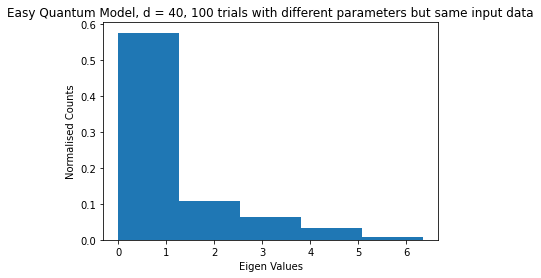

In [16]:
import matplotlib.pyplot as plt
plt.hist(eigen_values, bins = 5, density=True)
plt.title("Easy Quantum Model, d = 40, 100 trials with different parameters but same input data")
plt.xlabel("Eigen Values")
plt.ylabel("Normalised Counts")
plt.savefig("EasyQuantum40")
plt.show()

In [1]:
import pickle

In [2]:
file_name = "EasyQuantum40DiffParams.pkl"

open_file = open(file_name, "wb")
pickle.dump([data,fubini_matrices,eigen_vals,paramsV], open_file)
pickle.dump(fubini_matrices, open_file)
open_file.close()


NameError: name 'data' is not defined

In [3]:
open_file = open(file_name, "rb")
loaded_list = pickle.load(open_file)
open_file.close()

EOFError: Ran out of input

In [4]:
file_name = "EasyQuantum40DiffParams.pkl"
open_file = open(file_name, "rb")

In [5]:
loaded_list = pickle.load(open_file)

EOFError: Ran out of input

In [20]:
eigvals_bw01=[eigen_values[i] for i in range(len(eigen_values)) if eigen_values[i] <= 1]

In [21]:
eigvals_bw01

[-3.7697742209678493e-16,
 -9.97742573069182e-17,
 -2.8287354031400374e-17,
 8.014790977337235e-17,
 1.3147344498233138e-16,
 1.5515055145784482e-16,
 1.8361224994466824e-16,
 2.1005193284317476e-16,
 3.5514498880330814e-16,
 4.265104681911763e-16,
 1.1032970430786363e-15,
 0.029811337332482302,
 0.04238989152007335,
 0.04655206636929752,
 0.10267503336117305,
 0.13517582348079968,
 0.14995718507561953,
 0.1739371965317022,
 0.19996909089531784,
 0.3001825310047023,
 0.3522157387919134,
 0.40430854185532006,
 0.45756350138945756,
 0.5401809998368482,
 0.5993885709230143,
 0.6234157160125708,
 0.7003842396181917,
 0.9311702034358865,
 -4.4331134758242128e-16,
 -3.115421088110457e-16,
 -3.001800721602112e-16,
 -2.6751347280892813e-16,
 -2.6025616385236847e-16,
 -2.259636003368051e-16,
 -1.852337969472972e-16,
 -8.865268172713281e-17,
 2.547282855898175e-16,
 3.2891241039919943e-16,
 9.626145973086496e-16,
 0.040637994770754575,
 0.05251924985412782,
 0.07682376887098483,
 0.0973598447620

In [23]:
eigen_values

[-3.7697742209678493e-16,
 -9.97742573069182e-17,
 -2.8287354031400374e-17,
 8.014790977337235e-17,
 1.3147344498233138e-16,
 1.5515055145784482e-16,
 1.8361224994466824e-16,
 2.1005193284317476e-16,
 3.5514498880330814e-16,
 4.265104681911763e-16,
 1.1032970430786363e-15,
 0.029811337332482302,
 0.04238989152007335,
 0.04655206636929752,
 0.10267503336117305,
 0.13517582348079968,
 0.14995718507561953,
 0.1739371965317022,
 0.19996909089531784,
 0.3001825310047023,
 0.3522157387919134,
 0.40430854185532006,
 0.45756350138945756,
 0.5401809998368482,
 0.5993885709230143,
 0.6234157160125708,
 0.7003842396181917,
 0.9311702034358865,
 1.3362450029712407,
 1.4312107154965625,
 1.5556049836432717,
 1.7420848931346158,
 1.9190268551625012,
 2.2671954505364655,
 3.077536949472041,
 3.2632600092543362,
 3.4267541560546912,
 3.780863890866951,
 4.18302495497753,
 4.605477261431823,
 -4.4331134758242128e-16,
 -3.115421088110457e-16,
 -3.001800721602112e-16,
 -2.6751347280892813e-16,
 -2.602561